This notebook contains logistic regression for several violation categories (separate and combined). This notebook does not use the 'holiday' variable.

The violations types that we chose are based on total number of traffic stops and citation rates. These violation types are among top 30 (largest number of stops) and have citation rates < 90% and > 5%: 

['Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)',

'Ride, Not Secured By Safety Belt-Passenger (When Required)',

'Disregard Stop Sign (#)',

'No Valid Inspection Certificate-Expired (#)',

'Display Expired License Plates/Registration (#)',

'Use Of Vision Reducing Matter On Windows - Glass Coating Material']



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [ ]:
keep_col = ['county_name', 
            'subject_race',
            'subject_sex',
            'violation', 
            'citation_issued'
            ]
rm_na_col = ['county_name','violation','subject_race','subject_sex']

def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)

def preprocess(year, keep_col, rm_na_col, violation_type = 'all'):
  # read dataframe
  filename = '/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print('# of All traffic stops: ', len(df))

  if violation_type != 'all':
    print('Filtering: ', violation_type)
    df = df.loc[df['violation'] == violation_type,:]

  else:
    vios = ['Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)','Ride, Not Secured By Safety Belt-Passenger (When Required)',
       'Disregard Stop Sign (#)','No Valid Inspection Certificate-Expired (#)','Display Expired License Plates/Registration (#)',
        'Use Of Vision Reducing Matter On Windows - Glass Coating Material']
    
    print('Filtering: violations combined')
    df = df.loc[df['violation'].isin(vios),:]

  # invalid value
  if year == 2013:
    df.drop(df.index[df['lat'] == 74.052879], inplace=True)

  ## drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)

  ## County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/gdrive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county'] = [name[:-7] for name in df['county_name']]
  df['county'] = df['county'].replace('Dewitt','DeWitt')
  df = df.join(county_df.set_index('County Name'), on='county')
  df.drop('county', axis = 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  # Convert 'citation issued' to integer
  df = df.astype({'citation_issued': 'int64'})

  # if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()

  print(df['subject_sex'].value_counts(dropna = False))
  print(df['subject_race'].value_counts(dropna = False))
  print(df['county_type'].value_counts(dropna = False))

  print('# of violation type traffic stops: ', len(df))
  return df 

In [ ]:
def run_year_analysis(keep_col, rm_na_col, df_years, violation):
  """
  Input:
  #data_path: the folder path where all the yearly-based parquet files are saved

  #output_path: output path for csv files -> not used yet, because I want to print out the result and directly 
  #save it afterwards. After we make sure there is no problem about how I did the analysis, we integrate this part
  #into the function

  keep_col, rm_na_col,violation_type: parameters for preprocessing
  df_years: an empty data frame where we can save the logistic regression results
  model: 'baseline' or 'interaction'
  Output:
  A result dataframe
  """
  if violation == 'No Valid Inspection Certificate-Expired (#)':
    years = list(range(2006, 2016))
    print('Branch 1')
  elif (violation == 'Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)') or (violation =='Ride, Not Secured By Safety Belt-Passenger (When Required)'):
    years = list(range(2010, 2018))
    print('Branch 2')
  elif violation == 'all':
    years = list(range(2010, 2016))
    print('Correct Branch')
  else:
    years = list(range(2006, 2018))
    print('Branch 4')
  for year in years:
    # read in the data
    print('***********************************')
    print(year)

    # read in and preprocess data
    df = preprocess(year, keep_col, rm_na_col, violation_type = violation)
    if len(df) == 0:
      print('WARNING: ',violation,' has 0 records in ', year, '!!')
      return 0
    y = df['citation_issued']
    X = df.drop('citation_issued', axis = 1)
    X.drop(['county_name','violation'], axis = 1, inplace = True)
    
    # Those columns also contain no useful information. So, we drop those columns
    #for col in X.columns:
      #if len(X.loc[X[col] == 0,:]) == len(X):
        #X.drop(col, axis = 1, inplace = True)
        #print(year, ': ','Delete ', col)
    
    # get dummies for race, sex, daylight,holiday
    X = pd.get_dummies(X)
    #sex_dict = {'male':0, 'female':1}
    #X['subject_sex'] = X['subject_sex'].map(sex_dict)
    # for baseline model
    # Base level: male, White, Metropolitan (county type), holiday = 0
    X.drop(['subject_race_white', 'county_type_Metropolitan','subject_sex_male'], axis = 1, inplace = True)

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})

    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)), 
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file


### For each type of violation separately

Branch 2
***********************************
2010
# of All traffic stops:  2525296
Filtering:  Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)
male      25815
female     6291
Name: subject_sex, dtype: int64
white                     18736
hispanic                   9892
black                      3201
asian/pacific islander      277
Name: subject_race, dtype: int64
Metropolitan    20764
Non core         6156
Micropolitan     5186
Name: county_type, dtype: int64
# of violation type traffic stops:  32106


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.566643
         Iterations 5
***********************************
2011
# of All traffic stops:  2588004
Filtering:  Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)
male      24603
female     5872
Name: subject_sex, dtype: int64
white                     18001
hispanic                   8874
black                      3335
asian/pacific islander      265
Name: subject_race, dtype: int64
Metropolitan    20257
Non core         5930
Micropolitan     4288
Name: county_type, dtype: int64
# of violation type traffic stops:  30475
Optimization terminated successfully.
         Current function value: 0.611947
         Iterations 5
***********************************
2012
# of All traffic stops:  2435812
Filtering:  Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)
male      23507
female     5720
Name: subject_sex, dtype: int64
white                     17036
hispanic                   8682
black                  

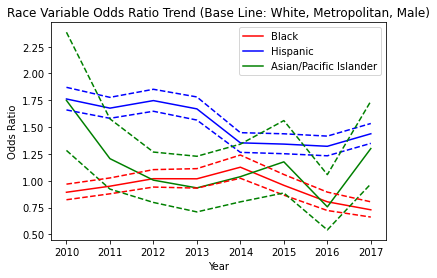

Branch 2
***********************************
2010
# of All traffic stops:  2525296
Filtering:  Ride, Not Secured By Safety Belt-Passenger (When Required)
male      9623
female    5902
Name: subject_sex, dtype: int64
hispanic                  7492
white                     6158
black                     1659
asian/pacific islander     216
Name: subject_race, dtype: int64
Metropolitan    9617
Non core        3325
Micropolitan    2583
Name: county_type, dtype: int64
# of violation type traffic stops:  15525
Optimization terminated successfully.
         Current function value: 0.654808
         Iterations 4
***********************************
2011


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# of All traffic stops:  2588004
Filtering:  Ride, Not Secured By Safety Belt-Passenger (When Required)
male      9729
female    5665
Name: subject_sex, dtype: int64
hispanic                  7567
white                     5788
black                     1737
asian/pacific islander     302
Name: subject_race, dtype: int64
Metropolitan    9810
Non core        3136
Micropolitan    2448
Name: county_type, dtype: int64
# of violation type traffic stops:  15394
Optimization terminated successfully.
         Current function value: 0.649670
         Iterations 5
***********************************
2012
# of All traffic stops:  2435812
Filtering:  Ride, Not Secured By Safety Belt-Passenger (When Required)
male      9554
female    5159
Name: subject_sex, dtype: int64
hispanic                  7153
white                     5542
black                     1733
asian/pacific islander     285
Name: subject_race, dtype: int64
Metropolitan    9526
Non core        2777
Micropolitan    2410
Name: count

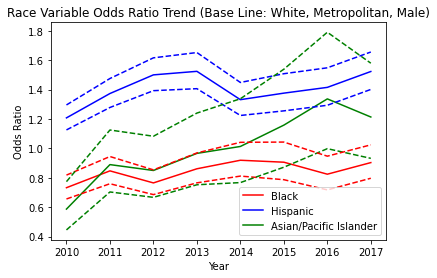

Branch 4
***********************************
2006
# of All traffic stops:  2693894
Filtering:  Disregard Stop Sign (#)
male      8635
female    4982
Name: subject_sex, dtype: int64
white                     9316
hispanic                  3456
black                      741
asian/pacific islander     104
Name: subject_race, dtype: int64
Metropolitan    7904
Micropolitan    3041
Non core        2672
Name: county_type, dtype: int64
# of violation type traffic stops:  13617
Optimization terminated successfully.
         Current function value: 0.624434
         Iterations 5
***********************************
2007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# of All traffic stops:  2427347
Filtering:  Disregard Stop Sign (#)
male      7470
female    4079
Name: subject_sex, dtype: int64
white                     7907
hispanic                  2953
black                      602
asian/pacific islander      87
Name: subject_race, dtype: int64
Metropolitan    6850
Micropolitan    2451
Non core        2248
Name: county_type, dtype: int64
# of violation type traffic stops:  11549
Optimization terminated successfully.
         Current function value: 0.627549
         Iterations 5
***********************************
2008
# of All traffic stops:  2526783
Filtering:  Disregard Stop Sign (#)
male      7420
female    4231
Name: subject_sex, dtype: int64
white                     8984
hispanic                  1919
black                      646
asian/pacific islander     102
Name: subject_race, dtype: int64
Metropolitan    6656
Non core        2578
Micropolitan    2417
Name: county_type, dtype: int64
# of violation type traffic stops:  11651
Optimiz

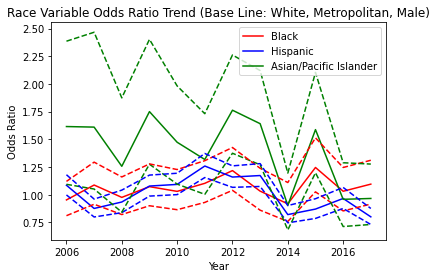

Branch 1
***********************************
2006
# of All traffic stops:  2693894
Filtering:  No Valid Inspection Certificate-Expired (#)
male      13218
female     6952
Name: subject_sex, dtype: int64
white                     15014
hispanic                   3045
black                      1853
asian/pacific islander      258
Name: subject_race, dtype: int64
Metropolitan    15263
Non core         2680
Micropolitan     2227
Name: county_type, dtype: int64
# of violation type traffic stops:  20170
Optimization terminated successfully.
         Current function value: 0.668510
         Iterations 4
***********************************
2007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# of All traffic stops:  2427347
Filtering:  No Valid Inspection Certificate-Expired (#)
male      12387
female     6555
Name: subject_sex, dtype: int64
white                     13848
hispanic                   3070
black                      1781
asian/pacific islander      243
Name: subject_race, dtype: int64
Metropolitan    14080
Non core         2684
Micropolitan     2178
Name: county_type, dtype: int64
# of violation type traffic stops:  18942
Optimization terminated successfully.
         Current function value: 0.681830
         Iterations 4
***********************************
2008
# of All traffic stops:  2526783
Filtering:  No Valid Inspection Certificate-Expired (#)
male      12696
female     6413
Name: subject_sex, dtype: int64
white                     14591
hispanic                   2637
black                      1614
asian/pacific islander      267
Name: subject_race, dtype: int64
Metropolitan    13160
Non core         3482
Micropolitan     2467
Name: county_type, dtyp

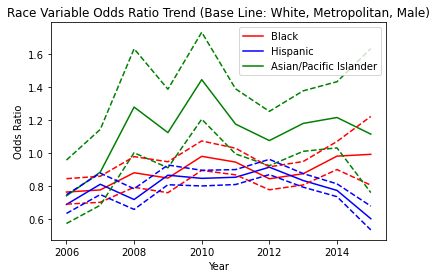

Branch 4
***********************************
2006
# of All traffic stops:  2693894
Filtering:  Display Expired License Plates/Registration (#)
male      14361
female     7581
Name: subject_sex, dtype: int64
white                     15506
hispanic                   4238
black                      1998
asian/pacific islander      200
Name: subject_race, dtype: int64
Metropolitan    15624
Non core         3378
Micropolitan     2940
Name: county_type, dtype: int64
# of violation type traffic stops:  21942
Optimization terminated successfully.
         Current function value: 0.586446
         Iterations 5
***********************************
2007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# of All traffic stops:  2427347
Filtering:  Display Expired License Plates/Registration (#)
male      9879
female    5029
Name: subject_sex, dtype: int64
white                     10029
hispanic                   3398
black                      1352
asian/pacific islander      129
Name: subject_race, dtype: int64
Metropolitan    9618
Non core        3004
Micropolitan    2286
Name: county_type, dtype: int64
# of violation type traffic stops:  14908
Optimization terminated successfully.
         Current function value: 0.559196
         Iterations 5
***********************************
2008
# of All traffic stops:  2526783
Filtering:  Display Expired License Plates/Registration (#)
male      10775
female     5270
Name: subject_sex, dtype: int64
white                     11954
hispanic                   2646
black                      1293
asian/pacific islander      152
Name: subject_race, dtype: int64
Metropolitan    9759
Non core        3599
Micropolitan    2687
Name: county_type, dtyp

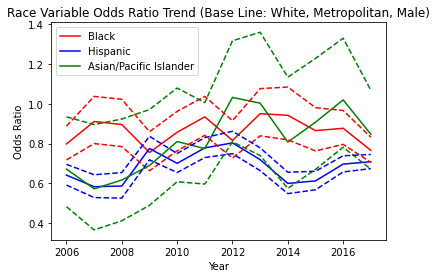

Branch 4
***********************************
2006
# of All traffic stops:  2693894
Filtering:  Use Of Vision Reducing Matter On Windows - Glass Coating Material
male      7383
female    2269
Name: subject_sex, dtype: int64
hispanic                  5576
white                     3526
black                      530
asian/pacific islander      20
Name: subject_race, dtype: int64
Metropolitan    4449
Non core        2684
Micropolitan    2519
Name: county_type, dtype: int64
# of violation type traffic stops:  9652
Optimization terminated successfully.
         Current function value: 0.504615
         Iterations 6
***********************************
2007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# of All traffic stops:  2427347
Filtering:  Use Of Vision Reducing Matter On Windows - Glass Coating Material
male      7538
female    2324
Name: subject_sex, dtype: int64
hispanic                  5617
white                     3707
black                      511
asian/pacific islander      27
Name: subject_race, dtype: int64
Metropolitan    4142
Non core        3156
Micropolitan    2564
Name: county_type, dtype: int64
# of violation type traffic stops:  9862
Optimization terminated successfully.
         Current function value: 0.514901
         Iterations 6
***********************************
2008
# of All traffic stops:  2526783
Filtering:  Use Of Vision Reducing Matter On Windows - Glass Coating Material
male      7672
female    2585
Name: subject_sex, dtype: int64
white                     5796
hispanic                  4011
black                      425
asian/pacific islander      25
Name: subject_race, dtype: int64
Metropolitan    3905
Non core        3544
Micropolitan    280

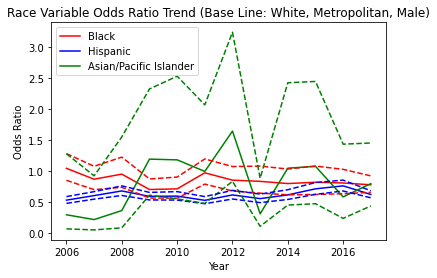

In [ ]:
vios = ['Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)','Ride, Not Secured By Safety Belt-Passenger (When Required)',
        'Disregard Stop Sign (#)','No Valid Inspection Certificate-Expired (#)','Display Expired License Plates/Registration (#)',
        'Use Of Vision Reducing Matter On Windows - Glass Coating Material']
filename_vios = ['safety_belt_driver','safety_belt_passenger','disregard_stop_sign','inspect_certficate_expired',
                 'expried_license','glass_coating']
# 'Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)','Ride, Not Secured By Safety Belt-Passenger (When Required)'
#'safety_belt_driver','safety_belt_passenger'
name_dict = {k:v for k,v in zip(vios, filename_vios)}

for vio in vios:
  #### MODIFY HERE!! GET LIST OF COLUMN NAMES
  #var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                      #'holiday', 'county_type_Non core', 'county_type_Micropolitan',
                      #'hispanic_metro','black_metro','asian/paci_metro']

  var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                      'county_type_Non core', 'county_type_Micropolitan','subject_sex_female']

  # num_feat = len(df_16.columns)

  # this df is later pass into run_year_analysis to get all estimates
  #df_years = pd.DataFrame({'variable':var_lst_interaction})
  df_years = pd.DataFrame({'variable':var_lst_baseline})

  # keep track of coefficient estimates and evaluation metrics
  asianpacific = []	
  black = []	
  hispanic = []	

  asianpacific_low = []	
  black_low = []	
  hispanic_low = []

  asianpacific_high = []	
  black_high = []	
  hispanic_high = []

  res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years, violation = vio)
  if not isinstance(res_df, pd.DataFrame):
    continue

  # save csv
  file_name = 'ORCI_'+name_dict[vio]+'.csv'
  save_path = '/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/' + file_name
  res_df.to_csv(save_path)

  # save plots

  if vio == 'No Valid Inspection Certificate-Expired (#)':
    years = list(range(2006, 2016))
  elif (vio == 'Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)') or (vio == 'Ride, Not Secured By Safety Belt-Passenger (When Required)'):
    years = list(range(2010, 2018))
  else:
    years = list(range(2006, 2018))
  
  sns.lineplot(x = years, y = black, color = 'red', label="Black")
  sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
  sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

  sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

  sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')

  plt.title('Race Variable Odds Ratio Trend (Base Line: White, Metropolitan, Male)')
  plt.xlabel('Year')
  plt.ylabel('Odds Ratio')
  plt.legend()
  plt.savefig(('/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/'+'ORCI_'+name_dict[vio]+'.svg'), format = 'svg')
  plt.savefig(('/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/'+'ORCI_'+name_dict[vio]+'.jpg'), dpi = 200)
  plt.show()

### For these violation types combined

Correct Branch
***********************************
2010
# of All traffic stops:  2525296
Filtering: violations combined
male      85651
female    37662
Name: subject_sex, dtype: int64
white                     67098
hispanic                  44603
black                     10141
asian/pacific islander     1471
Name: subject_race, dtype: int64
Metropolitan    78455
Non core        25037
Micropolitan    19821
Name: county_type, dtype: int64
# of violation type traffic stops:  123313


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.678872
         Iterations 4
***********************************
2011
# of All traffic stops:  2588004
Filtering: violations combined
male      88779
female    40152
Name: subject_sex, dtype: int64
white                     71423
hispanic                  44463
black                     11250
asian/pacific islander     1795
Name: subject_race, dtype: int64
Metropolitan    84540
Non core        25519
Micropolitan    18872
Name: county_type, dtype: int64
# of violation type traffic stops:  128931
Optimization terminated successfully.
         Current function value: 0.672373
         Iterations 4
***********************************
2012
# of All traffic stops:  2435812
Filtering: violations combined
male      85549
female    38191
Name: subject_sex, dtype: int64
white                     69028
hispanic                  41718
black                     11008
asian/pacific islander     1986
Name: subject_race, dtype: i

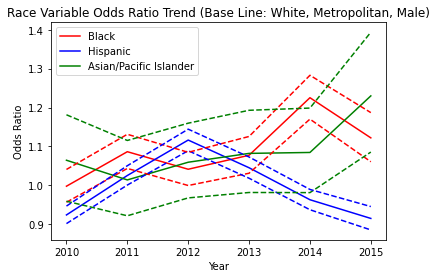

In [ ]:
# for violation types combined
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years,violation='all')

# save csv
file_name = 'ORCI_combined.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/' + file_name
res_df.to_csv(save_path)

years = list(range(2010, 2016))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')

plt.title('Race Variable Odds Ratio Trend (Base Line: White, Metropolitan, Male)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig(('/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/'+'ORCI_conbined.svg'), format = 'svg')
plt.savefig(('/gdrive/MyDrive/traffic_stop/output_0317/without_holiday/'+'ORCI_combined.jpg'), dpi = 200)
plt.show()

### Check violations and citation rates

'Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)'

'Ride, Not Secured By Safety Belt-Passenger (When Required)'

'Disregard Stop Sign (#)'

'No Valid Inspection Certificate-Expired (#)'

'Display Expired License Plates/Registration (#)'

'Use Of Vision Reducing Matter On Windows - Glass Coating Material'

Note that 2006-2009, the citation rates for safety belt-driver and safety belt-passenger are close to 1.

The citation rates for these two kinds of violations drop after 2010.

Note that in 2016-2017, 'No Valid Inspection Certificate-Expired (#)' is not among the violations.

After adjusting time frames for the violations above, all logistic regressions terminate succesfully before maximum iterations.

In [ ]:
def inspect_violation(year):
  df = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')
  print(year)
  print(df['violation'].value_counts(dropna=False)[:30])
  # use this when checking 2006-2015
  #top_vios = ['Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)','Ride, Not Secured By Safety Belt-Passenger (When Required)',
       #'Disregard Stop Sign (#)','No Valid Inspection Certificate-Expired (#)','Display Expired License Plates/Registration (#)',
        #'Use Of Vision Reducing Matter On Windows - Glass Coating Material']

  #use this when checking 2016-2017, bc 'No Valid Inspection Certificate-Expired (#)' is not in 2016 and 2017's violations
  top_vios = list(df['violation'].value_counts(dropna=False)[:30].index)
  violations = []
  citation_rates = []
  for vio in top_vios:
    temp_df = df.loc[df['violation']==vio,:]
    violations.append(vio)
    citation_rates.append(round(temp_df['citation_issued'].value_counts(dropna=False, normalize = True)[True],4))
  output_df = pd.DataFrame({'violation':violations,'citation_rate':citation_rates})
  print('*****************')
  print(output_df.sort_values(by = 'citation_rate', ascending = False))
  #return output_df.sort_values(by = 'citation_rate', ascending = False)

In [ ]:
df = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(2016) + '.parquet')
#df = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' + str(2017) + '.parquet')
print(df['violation'].value_counts(dropna=False)[:30])
'No Valid Inspection Certificate-Expired (#)' in list(df['violation'].value_counts(dropna=False)[:30].index)

Speeding Over Limit (#)                                                                      552698
Speeding-10% or More Above Posted Speed (#)                                                  226539
Operate Motor Vehicle Without License Plates (Or With One Plate)                              57819
No/Non-Compliant Head Lamps (#)                                                               40423
Display Expired License Plates/Registration (#)                                               29326
No/Improper License Plate Lamp                                                                29260
Improperly Placed Or Obstructed License Plate (#)                                             27973
Operate Motor Vehicle in Violation of FMVSS 571.108                                           20924
Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)                                         16623
Inoperable/Obscured Stop Lamp(s) (#)                                                          16441


False

In [ ]:
years = list(range(2006, 2016))
for year in years:
  inspect_violation(year)

2006
Speeding Over Limit (#)                                                                      767317
Speeding-10% or More Above Posted Speed (#)                                                  457629
No/Improper License Plate Lamp                                                                74549
Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)                                         64432
Operate Motor Vehicle Without License Plates (Or With One Plate)                              60842
Fail to Maintain Financial Responsibility (#)|Speeding-10% or More Above Posted Speed (#)     48648
No/Non-Compliant Head Lamps (#)                                                               39408
Speeding Over Limit (#)|Fail to Maintain Financial Responsibility (#)                         27825
Fail to Maintain Financial Responsibility (#)|Speeding Over Limit (#)                         27440
Improperly Placed Or Obstructed License Plate (#)                                             2

In [ ]:
for year in [2016, 2017]:
  inspect_violation(year)

2016
Speeding Over Limit (#)                                                                      552698
Speeding-10% or More Above Posted Speed (#)                                                  226539
Operate Motor Vehicle Without License Plates (Or With One Plate)                              57819
No/Non-Compliant Head Lamps (#)                                                               40423
Display Expired License Plates/Registration (#)                                               29326
No/Improper License Plate Lamp                                                                29260
Improperly Placed Or Obstructed License Plate (#)                                             27973
Operate Motor Vehicle in Violation of FMVSS 571.108                                           20924
Ride, Not Secured By Safety Belt-Driver (12-1-85) (#)                                         16623
Inoperable/Obscured Stop Lamp(s) (#)                                                          1